# Test Monte Carlo Tree Search

In [1]:
import numpy as np
from numpy.random import default_rng

from chess import Board
from IPython.display import Image, display

import sys

sys.path.append('../src')

from games.chess import KRK
from mcts.trees import GameSearchTree
from agents.random_policy import GameUniformPolicy

## Step by step

### Initialize game, policy and search tree

In [2]:
seed = 4
rng = default_rng(seed)

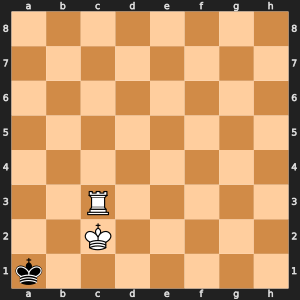

In [3]:
game = KRK()
state = game.initial_state
game.render(state)

In [4]:
random_policy = GameUniformPolicy(
    game=game,
    rng=rng,
    encoder=None,
)
random_policy.predict(state)

array([0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353,
       0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353,
       0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353,
       0.05882353, 0.05882353])

In [5]:
params = {
    "sim_limit": 100,
    "ucb_constant": 1,
    "beam_width": 3,
    "n_iterations": 3,
    "rng":rng
}

tree = GameSearchTree(
    root=state,
    game=game,
    rollout_policy=random_policy,
    **params
)

### Visualize root

In [6]:
print(tree.root)

State --root--
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . R . . . . .
. . K . . . . .
k . . . . . . .
Depth: 0
Reward/Visits: 0/0 (=0)



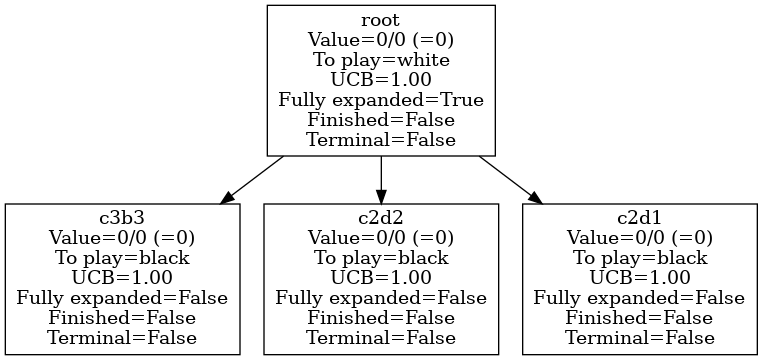

In [7]:
png_data = tree.to_pydot().create_png()
display(Image(png_data))

### Step 1: Leaf selection

In [8]:
node = tree.select_ucb()
print('Selected node:')
print(node)

Selected node:
State 
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. R . . . . . .
. . K . . . . .
k . . . . . . .
Depth: 1
Reward/Visits: 0/0 (=0)
From action: c3b3
Value: 0/0 (=0)



### Step 2: Leaf expansion

In [9]:
tree.expand_node(node)

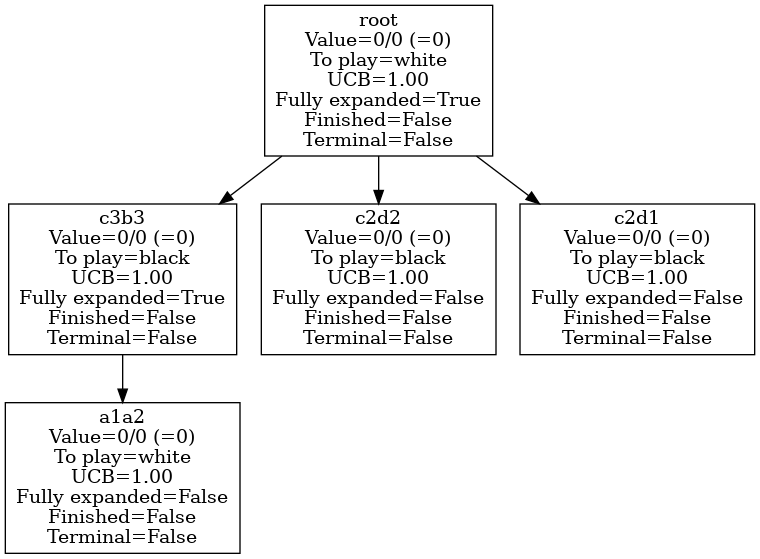

In [10]:
png_data = tree.to_pydot().create_png()
display(Image(png_data))

### Step 3: Rollout

In [11]:
rollout_result = tree.make_rollout(node)
print("Rollout result:", rollout_result)

Rollout result: -1


### Step 4: Backpropagate

In [12]:
tree.backpropagate(node, rollout_result)

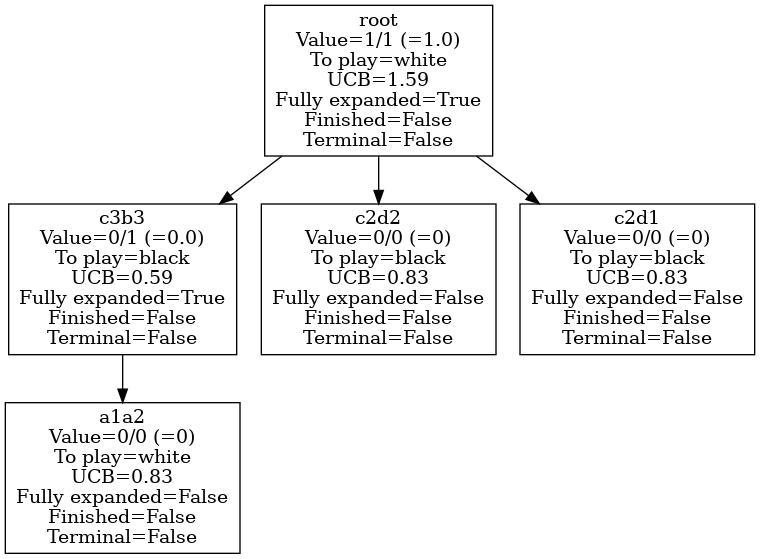

In [13]:
png_data = tree.to_pydot().create_png()
display(Image(png_data))

## All steps

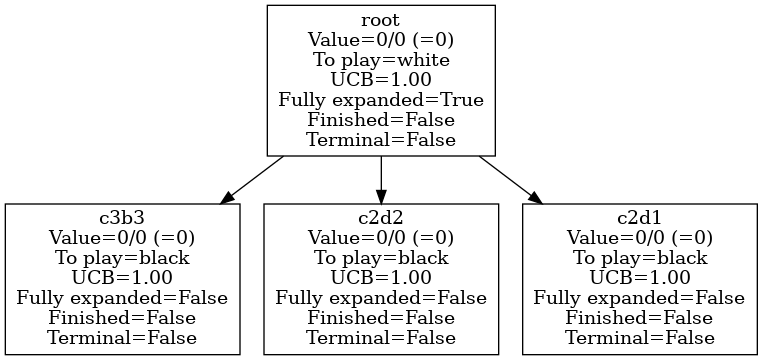

In [14]:
game = KRK()
state = game.initial_state

seed = 4
rng = default_rng(seed)

random_policy = GameUniformPolicy(
    game=game, 
    rng=rng,
    encoder=None,
)

params = {
    "sim_limit": 100,
    "ucb_constant": 1,
    "beam_width": 3,
    "n_iterations": 15,
    "rng":rng
}

tree = GameSearchTree(
    root=state,
    game=game,
    rollout_policy=random_policy,
    **params
)

png_data = tree.to_pydot().create_png()
display(Image(png_data))


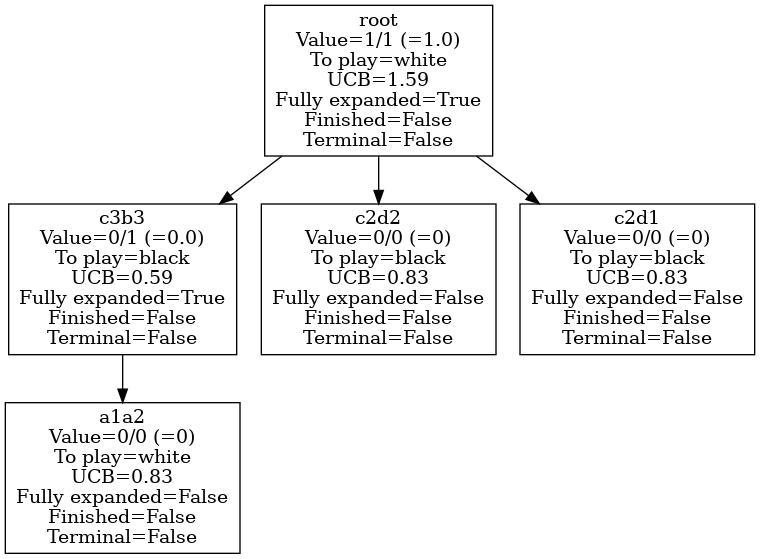

In [15]:
node = tree.select_ucb()
tree.expand_node(node)
rollout_result = tree.make_rollout(node)
tree.backpropagate(node, rollout_result)
png_data = tree.to_pydot().create_png()
display(Image(png_data))

### Iteration

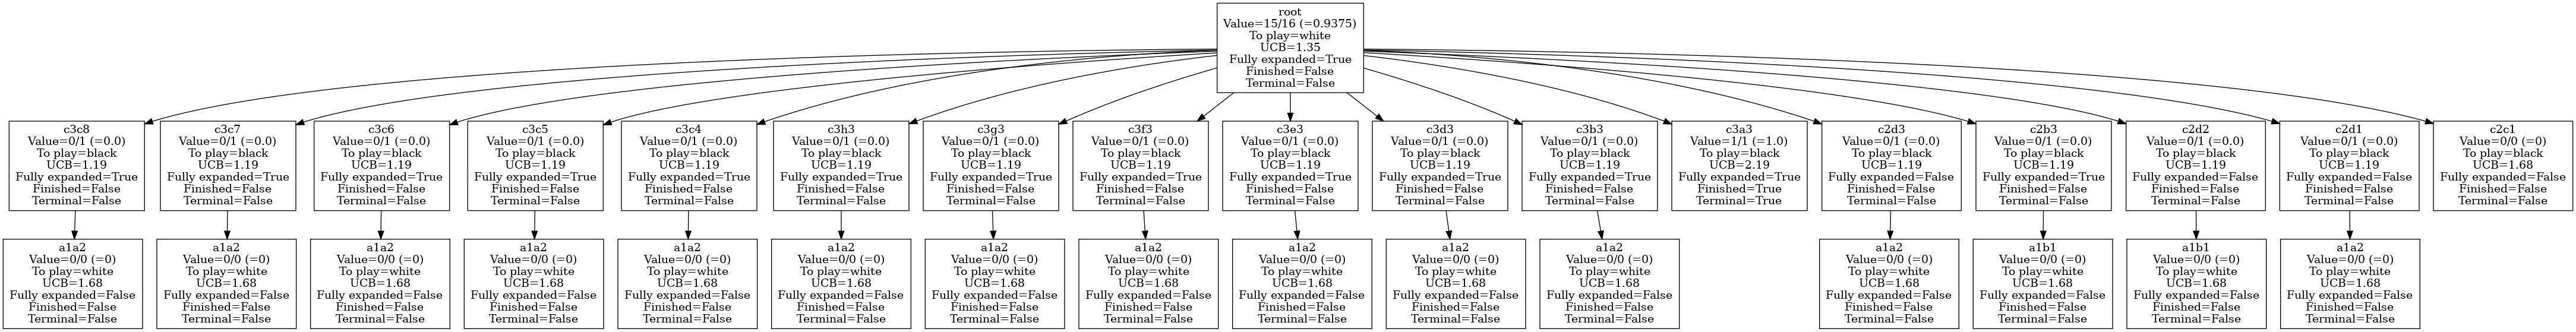

In [17]:
game = KRK()
state = game.initial_state

seed = 4
rng = default_rng(seed)

random_policy = GameUniformPolicy(
    game=game, rng=rng, encoder=None
)

params = {
    "sim_limit": 3,
    "ucb_constant": 1,
    "beam_width": np.inf,
    "n_iterations": 15,
    "rng":rng
}

tree = GameSearchTree(
    root=state,
    game=game,
    rollout_policy=random_policy,
    **params
)

counter = 0
while counter < tree.n_iterations:

    # Step 1: Node selection
    node = tree.select_ucb()
    if node is None:
        raise Exception(f"Ooops, no ucb selection from node {node}")
    if node.is_fully_expanded():
        raise Exception(f"Ooops, no expansion from node {node}")

    # Step 2: Expansion
    tree.expand_node(node)

    # Step 3: Rollout
    rollout_result = tree.make_rollout(node)

    # Step 4: Backpropagate
    tree.backpropagate(node, rollout_result)

    counter += 1

png_data = tree.to_pydot().create_png()
display(Image(png_data))

In [18]:
best_root_action = tree.get_best_root_action()
print('Best action:', best_root_action)

Best action: c3a3


## A more difficult example

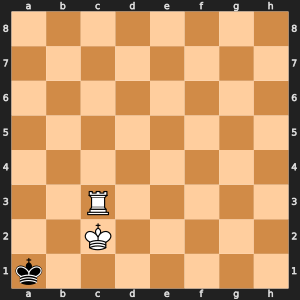

In [19]:
# Initialize game, random policy and MCTS parameters
game = KRK(start_position=3)
rollout_policy = GameUniformPolicy(
    game=game, rng=rng, encoder=None
)
params = {
    "sim_limit": 50,
    "ucb_constant": 1 / np.sqrt(2),
    "beam_width": np.inf,
    "n_iterations": 100,
    "rng":rng
}

# Show initial state
root = game.initial_state
game.render(state)

Best action: c1c8


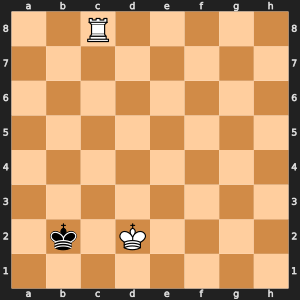

In [20]:
tree = GameSearchTree(
    root=root,
    game=game,
    rollout_policy=rollout_policy,
    **params
)

# Show best action
best_action = tree.make_decision()
print('Best action:', best_action)

# Make transition
state = tree.game.result(tree.root.state, best_action)
if tree.game.is_terminal(state):
    game.announce_result(state)
    utility = game.utility(state)
    print('Board utility:', utility)

# Prepare for next iteration
root = tree.get_root_child_from_action(best_action)

# Render
game.render(state)

---